# Optical Character Recognition of Japanese Characters



Using various models and methods to accurately classify Hiragana, Katakana and Kanji from handwritten images.

### Imports

In [2]:
import numpy as np
import pandas as pd
import os

import random

from sklearn import decomposition
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import utils
from sklearn import neighbors
from sklearn import svm

from skimage.measure import block_reduce


import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
fp = FontProperties(fname='./font/YuGothM.ttc', size=14)
rcParams['font.family'] = fp.get_name()

import PIL 
import PIL.Image
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D
from keras import metrics as kr_metrics
from keras.preprocessing.image import ImageDataGenerator
 

### Helper Functions

In [3]:
def separate(big_img, ht = 63, wd = 64):

    height = big_img.shape[0]
    width = big_img.shape[1]
    
    img_array = []
    num_down = int(height/ht)
    num_across = int(width/wd)


    for i in range(num_down):
        for j in range(num_across):  
            image = big_img[ht * i:ht + (ht * i)].T[(wd * j):wd + (wd * j)].T
            img_array.append(image)
                

    img_array = np.array(img_array)
    return img_array


In [4]:
def load_pair(folder, file):
    img_path = folder + file + '.png'
    img = PIL.Image.open(img_path)
    img = np.array(img)

    img_array = separate(img)
    
    txt_path = folder + file + '.txt'
    txt = open(txt_path, encoding='utf8').read()
    txt = txt.replace('\n', '')
    return (img_array, txt)
    

In [5]:
def load_data(folder_arch, file_arch, length, image_dict):
    folder = 'Data/' + folder_arch + '/'


    for i in range(length):
        if(i <= 9):
            i = '0' + str(i)
        else:
            i = str(i)
        file = file_arch + i
        images, labels = load_pair(folder, file)

        for j in range(len(labels)):
            image_dict[labels[j]].append(images[j])
    return image_dict


In [6]:
def disp(images, labels, index):
    plt.imshow(images[index])
    plt.title(labels[index])
    plt.show()

In [7]:
def do_downsample(data_images, scale):
  downsampled_images = []
  downsampled_flat = []
  for i in range(len(data_images)):
    ds_image = block_reduce(data_images[i], block_size = scale)
    downsampled_images.append(ds_image)
    downsampled_flat.append(ds_image.reshape(ds_image.shape[0] * ds_image.shape[1]))
  return np.array(downsampled_images),  np.array(downsampled_flat) 

In [8]:
def bad_classes(confm, classes):

    confm = confm.T

    worst_chars = (np.argsort(confm.diagonal()))[:3]
    worst_accs = np.sort(confm.diagonal())[:3]
    print(worst_accs)
    print(classes[worst_chars])

    char_1 = confm[worst_chars[0]]
    char_2 = confm[worst_chars[1]]
    char_3 = confm[worst_chars[2]]

    print(worst_chars[0])
    print(classes[worst_chars[0]])
    print(classes[np.argsort(-char_1)][:5])

    print()

    print(worst_chars[1])
    print(classes[worst_chars[1]])
    print(classes[np.argsort(-char_2)][:5])

    print()

    print(worst_chars[2])
    print(classes[worst_chars[2]])
    print(classes[np.argsort(-char_3)][:5])


### Load Data

In [9]:
image_dict = defaultdict(list)
for i in [1,2,3]:
  image_dict = load_data('ETL8B', 'ETL8B2C' + str(i) +'_', 26, image_dict)
for i in [1,2,3,4,5]:
  image_dict = load_data('ETL9B','ETL9B_' + str(i) + '_', 61, image_dict)

In [10]:
print(len(image_dict[None]))

0


In [11]:

#fresh_image_dict = defaultdict(list)
#fresh_image_dict = load_data('ETL4', 'ETL4C_' ,4, fresh_image_dict)
img_path = 'Data/ETL4/' + 'ETL4C_00' + '.png'
img = PIL.Image.open(img_path)
img = np.array(img)

img_array = separate(img, ht = 76, wd = 72)

cleaning_prototype = img_array[0]


[[48 64 48 ... 64 64 64]
 [48 48 64 ... 64 64 64]
 [64 64 64 ... 64 64 64]
 ...
 [64 64 64 ... 64 64 48]
 [64 64 64 ... 64 48 64]
 [64 64 64 ... 64 64 64]]


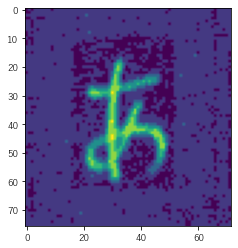

48
144
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


<function matplotlib.pyplot.show(close=None, block=None)>

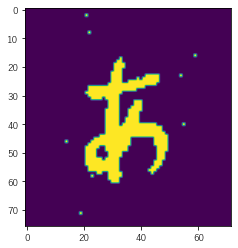

In [12]:
print(cleaning_prototype)
plt.imshow(cleaning_prototype)
plt.show()

threshold = 76
print(np.min(cleaning_prototype))
print(np.max(cleaning_prototype))



cleaned = cleaning_prototype > threshold
print(cleaned)
plt.imshow(cleaned)
plt.show

### Define data subsets

In [13]:
hiragana = ['あ','い','う','え','お',
'か','き','く','け','こ','が','ぎ','ぐ','げ','ご',
'さ','し','す','せ','そ','ざ','じ','ず','ぜ','ぞ',
'た','ち','つ','て','と','だ','ぢ','づ','で','ど',
'な','に','ぬ','ね','の',
'は','ひ','ふ','へ','ほ','ば','び','ぶ','べ','ぼ','ぱ','ぴ','ぷ','ぺ','ぽ',
'ま','み','む','め','も',
'や','ゆ','よ',
'ら','り','る','れ','ろ',
'わ','ゐ','ゑ','を','ん']


In [14]:
basic_kanji =  ['一','二','三','四','五','六','七','八',
                '九','十','百','千','万','日','大','年',
                '中','会','人','本','月','長','国','出',
                '上','生','子','分','東','行','同','今',
                '高','金','時','手','見','市','力','米',
                '自','前','円','合','立','内','事','社',
                '者','地','京','間','田','体','学','下',
                '目','後','新','明','方','部','女','心',
                '民','対','主','正','代','言','小','思',
                '山','実','入','回','場','野','開','全',
                '定','家','北','問','話','文','動','度',
                '県','水','安','氏','和','政','保','表',
                '道','相','意','発','不','党','曜','宅']

combined = hiragana + basic_kanji


hiragana = np.array(hiragana)
basic_kanji = np.array(basic_kanji)
combined = np.array(combined)

In [15]:
def make_datasets(image_dict, characterset):
    data_images = []
    data_labels = []
    data_flatten = []
    data_onehot = []

    for i in characterset:
        for image in image_dict[i]:
            data_flatten.append(image.reshape(63*64))
            data_images.append(image)
            data_labels.append(i)
    data_labels = np.array(data_labels)
    data_images = np.array(data_images)
    data_flatten = np.array(data_flatten)

    data_downsample, data_downsample_flat = do_downsample(data_images= data_images, scale=(2,2))

    for i in range(len(data_labels)):
        data_onehot.append(characterset == data_labels[i])
        
    data_onehot = np.array(data_onehot)


    utils.shuffle(data_labels, data_images, data_flatten,data_downsample ,data_downsample_flat, data_onehot)

    return data_labels, data_onehot, data_images, data_flatten, data_downsample, data_downsample_flat


In [16]:
def generate_class_labels (labels):
  class_labels = []
  for i in labels:
    if (np.any(i == hiragana)):
      class_labels.append('H')
    elif (np.any(i == basic_kanji)):
      class_labels.append('K')
  return class_labels 

In [17]:
hiragana_labels, hiragana_onehot, hiragana_images, hiragana_flatten, hiragana_downsample, hiragana_downsample_flat = make_datasets(image_dict, hiragana)
kanji_labels, kanji_onehot, kanji_images, kanji_flatten, kanji_downsample, kanji_downsample_flat = make_datasets(image_dict, basic_kanji)
combined_labels, combined_onehot, combined_images, combined_flatten, combined_downsample, combined_downsample_flat = make_datasets(image_dict, combined)

classes_combined = generate_class_labels(combined_labels)


### PCA

In [18]:
def do_pca(data):
    pca = decomposition.PCA(n_components=47)
    pca.fit(data)
    eigenchars = pca.components_ 
    data_tsf = pca.transform(data)

    return eigenchars, data_tsf

In [19]:
eigengana ,hiragana_tsf = do_pca(hiragana_flatten)
ds_eigengana , ds_hiragana_tsf = do_pca(hiragana_downsample_flat)

eigenkanji, kanji_tsf = do_pca(kanji_flatten)
ds_eigenkanji, ds_kanji_tsf = do_pca(kanji_downsample_flat)

eigencombined, combined_tsf = do_pca(combined_flatten)
ds_eigencombined, ds_combined_tsf = do_pca(combined_downsample_flat)

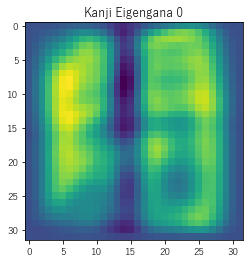

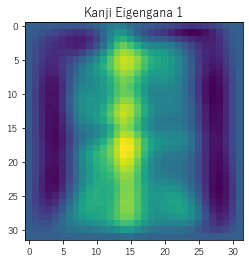

In [20]:
for i in range(2):
    plt.imshow(ds_eigenkanji[i].reshape(32,32))
    plt.title('Kanji Eigengana ' + str(i))
    plt.show()

## Model Functions

### Random Forest

In [21]:
def do_random_forest(data, labels):
    train_x, test_x , train_y, test_y= model_selection.train_test_split(data, labels)

    rf = ensemble.RandomForestClassifier()
    rf.fit(train_x, train_y)
    rf_pred = rf.predict(test_x)

    print('Random Forest Accuracy:')
    print(metrics.accuracy_score(test_y, rf_pred))
    
    rf_confm = metrics.confusion_matrix(test_y, rf_pred)
    plt.imshow(rf_confm)
    plt.title('Random Forest Confusion Matrix')
    plt.show()

    return rf_confm

### K Nearest Neighbors

In [22]:
def do_knn(data, labels, k):
    train_x, test_x , train_y, test_y= model_selection.train_test_split(data, labels)

    knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(train_x, train_y) 
    knn_pred = knn_model.predict(test_x)
    
    print('KNN Accuracy:')
    print(metrics.accuracy_score(test_y, knn_pred))

    knn_conf = metrics.confusion_matrix(test_y, knn_pred)
    plt.imshow(knn_conf)
    plt.title('KNN Confusion Matrix')
    plt.show()

    return knn_conf

### Support Vector Machines

In [23]:
def do_svm(data, labels):
    train_x, test_x , train_y, test_y= model_selection.train_test_split(data, labels)

    svms = svm.SVC(C = 10000, kernel = 'rbf', gamma=0.001)
    svms.fit(train_x, train_y) 
    svm_pred = svms.predict(test_x)

    print('SVM Accuracy:')
    print(metrics.accuracy_score(svm_pred, test_y))

    svm_conf = np.array(metrics.confusion_matrix(svm_pred, hgana_test_y))
    plt.imshow(svm_conf)
    plt.title('SVM Confusion Matrix')
    plt.show()
    
    return svm_conf

### Neural Networks

In [24]:
input_shape_2d = (32,32,1) 
input_shape_1d = (32*32,)
output_shape_h = len(hiragana)
output_shape_k = len(basic_kanji)
output_shape_c = output_shape_k + output_shape_h

In [25]:
def do_neural_net(data, labels, model, char_set, loss_fn = 'categorical_crossentropy', epochs = 15):
    train_x, test_x , train_y, test_y= model_selection.train_test_split(data, labels)

    model.compile(optimizer='adam', loss= loss_fn, metrics= ['accuracy' ])
    model.fit(x = train_x, y = train_y, batch_size=100, epochs = epochs, validation_split= 0.1)


    nn_pred = model.predict(test_x)
    nn_labels = []
    test_true = []
    for i in range(len(nn_pred)):
        nn_labels.append(char_set[np.argmax(nn_pred[i])])
        test_true.append(char_set[np.argmax(test_y[i])])

    print('Accuracy Score: ' + str(metrics.accuracy_score(test_true, nn_labels)))

    nn_conf = metrics.confusion_matrix(test_true, nn_labels, labels=char_set)
    plt.imshow(nn_conf)
    plt.title('Neural Net Confusion Matrix')
    plt.show()
    return nn_conf, model
        


# Create NN Models

In [26]:
hgana_model = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), input_shape=input_shape_2d, activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(192, (3,3), activation='relu'),
    keras.layers.Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(units = output_shape_h , activation = 'softmax')
])

In [27]:
kanji_model = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), input_shape=input_shape_2d, activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(192, (3,3), activation='relu'),
    keras.layers.Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(units = output_shape_k , activation = 'softmax')
])

In [28]:
combined_model = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), input_shape=input_shape_2d, activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(192, (3,3), activation='relu'),
    keras.layers.Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(units = output_shape_k , activation = 'softmax')
])

In [29]:

#nn_hgana_confm = do_neural_net(kanji_downsample, kanji_onehot, kanji_model, basic_kanji)

#bad_classes(nn_hgana_confm, basic_kanji)

In [30]:
#kanji_best_model = do_neural_net(kanji_downsample, kanji_onehot, kanji_model, basic_kanji)

In [31]:
#combo_best_model = do_neural_net(combined_downsample, combined_onehot, kanji_model, combined)


In [32]:
#combo_best_model.summary

In [33]:
model = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), input_shape=input_shape_2d, activation = 'relu'),
    keras.layers.Flatten(),

])

In [34]:
#model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy' ])
#model.fit(x = hiragana_downsample, batch_size=100, epochs = 10, validation_split= 0.1)


In [35]:
#conf, trained = do_neural_net(kanji_downsample_flat, kanji_onehot, model, basic_kanji, loss_fn = 'categorical_crossentropy', epochs = 10)

#model = do_neural_net(kanji_downsample, kanji_onehot, model, basic_kanji, loss_fn = 'categorical_crossentropy', epochs = 10)

#model = do_neural_net(combined_downsample, combined_onehot, model, combined, loss_fn = 'categorical_crossentropy', epochs = 10)


In [36]:
kanji_best_model.layers

NameError: name 'kanji_best_model' is not defined

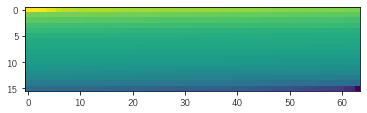

[392  93 304 ... 646 597 423]


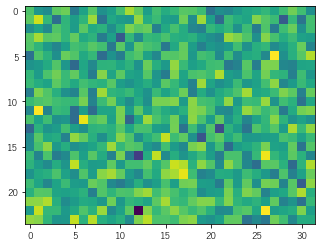

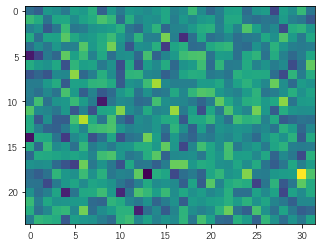

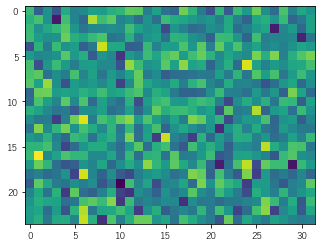

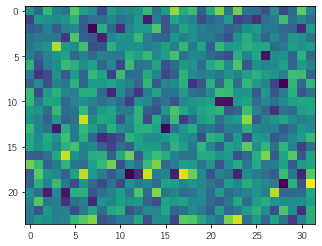

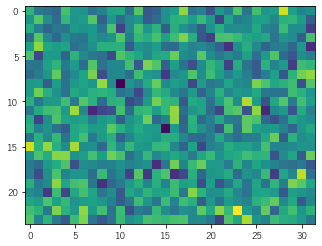

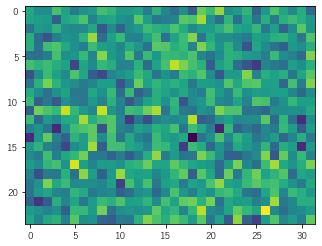

In [ ]:
weighs = np.array(kanji_best_model.layers[7].weights[0]).T
weighs_1 = np.array(kanji_best_model.layers[7].weights[1]).T

best_weights = np.argsort(-(weighs_1))

plt.imshow(weighs_1[best_weights].reshape(16,-1))
plt.show()
print(best_weights)
for i in best_weights[:6]: 
    plt.imshow(weighs[i].reshape(24,32))
    plt.show()